In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import os
import seaborn as sns
from proj1_helpers import *

SEED = 56

In [2]:
#its my datapath
DATA_TRAIN_PATH = r'C:/Users/Tomas/GitHub/ML_course/projects/project1/data/train1.csv/train.csv' # TODO: download train data and supply path here
y, tx, ids = load_csv_data(DATA_TRAIN_PATH)
print(y.shape)
print(tx.shape)
print(ids.shape)

(250000,)
(250000, 30)
(250000,)


In [3]:
#manipulate -999 values
def manipulate_missing_values(tx):
    tx[tx == -999.0] = np.nan
    avg_column = np.array([np.nanmean(tx, axis=0)])
    avg_column_ = np.repeat(avg_column, tx.shape[0], axis=0)
    one_dim_indices_to_subst = np.where(np.isnan(tx))
    two_dim_indices_to_subst = np.squeeze(np.dstack((one_dim_indices_to_subst[0],one_dim_indices_to_subst[1])), axis=0)
    tx[two_dim_indices_to_subst] = avg_column_[two_dim_indices_to_subst]
    return tx
tx = manipulate_missing_values(tx)

In [4]:
#rmse calculation
def compute_error(y, tx, w):
    e = y-np.matmul(tx, w)
    return e

def compute_loss(y, tx, w):
    N = len(y)
    e = compute_error(y, tx, w)
    mse = 1/(2*N)*np.sum(e**2)
    rmse = np.sqrt(2*mse)
    return rmse

In [5]:
#gradient descent
def compute_gradient(y, tx, w):
    N = len(y)
    e = compute_error(y, tx, w)
    grad = (-1/N)*np.matmul(tx.T,e)
    return grad

def least_squares_GD(y, tx, initial_w, max_iters, gamma):
    w = initial_w
    for n_iter in range(max_iters):
        grad = compute_gradient(y, tx, w)
        w -= gamma*grad
    loss = compute_loss(y, tx, w)
    print("Gradient Descent: train loss is ", loss)
    return w, loss

In [6]:
#stochastic gradient descent
def compute_stoch_gradient(y, tx, w):
    N = len(y)
    e = compute_error(y, tx, w)
    grad = (-1/N)*np.matmul(tx.T,e)
    return grad

def least_squares_SGD(y, tx, initial_w, max_iters, gamma,  batch_size = 1):
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        for ymini, txmini in batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
            grad = compute_gradient(ymini, txmini, w)
            w -= gamma*grad
    loss = compute_loss(ymini, txmini, w)
    print("Stochastic Gradient Descent: train loss is ", loss)
    return w, loss

In [7]:
#least squares
def least_squares(y, tx):
    N = len(y)
    w = np.linalg.solve(np.matmul(tx.T, tx), np.matmul(tx.T,y))
    loss = compute_loss(y, tx, w)
    print("Least squares: train loss is ", loss)
    return w, loss

In [8]:
#ridge regression
def ridge_regression(y, phi, lambda_):
    N=len(phi)
    lambda_acc=2*N*lambda_
    kwad = np.matmul(phi.T,phi)
    w = np.linalg.solve(kwad+lambda_acc*np.eye(kwad.shape[0]),np.matmul(phi.T,y))
    loss = compute_loss(y, phi, w)
    print("Ridge regression: train loss is ", loss)
    return w, loss

In [9]:
#helper functions for logistic regression
def sigmoid(t):
    """apply the sigmoid function on t."""
    return 1/(1 + np.exp(-t))

def calculate_loss_lr(y, tx, w):
    eps = 1e-6
    """compute the loss: negative log likelihood."""
    pred = sigmoid(np.matmul(tx, w))
    a = np.matmul(y.T, np.log(pred+eps)) 
    b = np.matmul((1-y).T, np.log(1-pred+eps))
    loss = a+b
    return np.sum(- loss)

def calculate_gradient_lr(y, tx, w):
    """compute the gradient of loss."""
    pred = sigmoid(np.matmul(tx, w)) 
    grad = np.matmul(tx.T,(pred - y))
    return grad

def penalized_logistic_regression(y, tx, w, lambda_):
    """return the loss, gradient"""
    loss = calculate_loss_lr(y, tx, w) + lambda_*np.sum(w.T.dot(w))
    gradient = calculate_gradient_lr(y,tx,w)+2*lambda_*w
    return loss, gradient

In [10]:
#logistic regression gradient descent
def logistic_regression_gd(y, tx, initial_w, max_iters, gamma):
    w = initial_w
    for iter in range(max_iters):
        grad = calculate_gradient_lr(y, tx, w)
        w -= gamma*grad
        #loss = calculate_loss_lr(y, tx, w)
        #print(loss)
    loss = calculate_loss_lr(y, tx, w)
    print("Logistic regression: train loss is ", loss)
    return w, loss

In [11]:
#regularized logistic regression
def logistic_regression_reg(y, tx, initial_w, max_iters, gamma, lambda_):
    w = initial_w
    for iter in range(max_iters):
        grad = penalized_logistic_regression(y, tx, w, lambda_)[1]
        w -= gamma*grad
    loss = penalized_logistic_regression(y, tx, w, lambda_)[0]
    print("Regularized logistic regression: train loss is ", loss)
    return w, loss

# 2) Evaluation

In [12]:
#polynomial feature augmentation
def build_poly(x, degree):
    #prof flammarion said it is possible, but i would wait a bit with doing it
    return x
"""def build_poly(x, degree):
    if degree == 0:
        return x
    else:
        N = len(x)
        phi = np.zeros((N,degree+1))
        for i in range(degree+1):
            phi[:, i] = x**i
        return phi"""

"""def build_poly_2d(x, degree):
    N,M = x.shape
    phi = np.zeros((N,M*(degree+1)))
    print(phi.shape)
    for i in range(M):
        col = x[:,i]
        exp = build_poly(col, degree)
        phi[:, i*(degree+1):(i+1)*(degree)] = exp
    return phi
x = np.array([[1,2,3],[4,5,6]])
print(build_poly_2d(x, 1))"""


'def build_poly_2d(x, degree):\n    N,M = x.shape\n    phi = np.zeros((N,M*(degree+1)))\n    print(phi.shape)\n    for i in range(M):\n        col = x[:,i]\n        exp = build_poly(col, degree)\n        phi[:, i*(degree+1):(i+1)*(degree)] = exp\n    return phi\nx = np.array([[1,2,3],[4,5,6]])\nprint(build_poly_2d(x, 1))'

In [13]:
def f1(y_true, y_pred):
    TP = len(np.where((y_true == 1) & (y_pred == 1))[0])
    FP = len(np.where((y_true == -1) & (y_pred == 1))[0])
    TN = len(np.where((y_true == -1) & (y_pred == -1))[0])
    FN = len(np.where((y_true == 1) & (y_pred == -1))[0])
    print([TP,FP,TN,FN])
    if TP+FN>0:
        Recall = TP/(TP+FN)
    else:
        Recall = 0.0001
    if TP+FP>0:
        Precision = TP/(TP+FP)
    else:
        Precision = 0.00001
    return 2*Recall*Precision/(Recall + Precision)

In [14]:
def accuracy(y_true, y_pred):
    TP = len(np.where((y_true == 1) & (y_pred == 1))[0])
    return (TP / y_true.shape[0])

In [15]:
#cross validation
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)


def cross_validation(y, x, k_indices, k, degree, opt_method, initial_w, max_iters, gamma, lambda_):
    x_train_0, y_train_0 = x[k_indices[:k].ravel()], y[k_indices[:k].ravel()]
    x_train_1, y_train_1 = x[k_indices[k+1:].ravel()], y[k_indices[k+1:].ravel()]
    if x_train_0.shape[0] == 0:
        x_train = x_train_1
        y_train = y_train_1
    if x_train_1.shape[0] == 0:
        x_train = x_train_0
        y_train = y_train_0
    else:
        x_train, y_train = np.concatenate((x_train_0, x_train_1), axis=0), np.concatenate((y_train_0, y_train_1), axis=0)
    
    x_test, y_test = x[k_indices[k]], y[k_indices[k]]
    # get k'th subgroup in test, others in train

    
    phi_train = build_poly(x_train, degree)
    phi_test = build_poly(x_test, degree)
    
    if opt_method == least_squares_GD:
        w, loss_tr = opt_method(y_train, phi_train, initial_w, max_iters, gamma)
        loss_te = compute_loss(y_test, phi_test, w)
        
        #print('least_squares_GD')

    elif opt_method == least_squares_SGD:
        w, loss_tr = opt_method(y_train, phi_train, initial_w, max_iters, gamma,  batch_size = 1)
        loss_te = compute_loss(y_test, phi_test, w)
        #print('least_squares_SGD')
    
    elif opt_method == least_squares:
        w, loss_tr = opt_method(y_train, phi_train)
        loss_te = compute_loss(y_test, phi_test, w)
        #print('least_squares')

    elif opt_method == ridge_regression:
        w, loss_tr = opt_method(y_train, phi_train, lambda_)
        loss_te = compute_loss(y_test, phi_test, w)
        #print('ridge_regression')

    elif opt_method == logistic_regression_gd:
        w, loss_tr = opt_method(y_train, phi_train, initial_w, max_iters, gamma)
        loss_te = calculate_loss_lr(y_test, phi_test, w)
        #print('logistic_regression_gd')

    elif opt_method == logistic_regression_reg:
        w, loss_tr = opt_method(y_train, phi_train, initial_w, max_iters, gamma, lambda_)
        loss_te = penalized_logistic_regression(y_test, phi_test, w, lambda_)[0]
        #print('reg_logistic_regression')

    else:
        w, loss = (None , None)
        test_loss = None
        #print("Method not found")
    
    
    y_pred_tr = predict_labels(w, phi_train)
    y_pred_te = predict_labels(w, phi_test)
    acc_train = accuracy(y_train, y_pred_tr)
    f1_train = f1(y_train, y_pred_tr)
    acc_test = accuracy(y_test, y_pred_te)
    f1_test = f1(y_test, y_pred_te)
    
    loss = [loss_tr, loss_te]
    acc = [acc_train, acc_test]
    f1_val = [f1_train, f1_test]
    
    return loss, acc, f1_val, w

In [16]:
def apply_cross_validation(y, x, k_indices, k_fold, degree, opt_method, initial_w = 0, max_iters = 0, gamma = 0, lambda_ = 0):
    loss_tr = []
    loss_te = []
    acc_tr = []
    acc_te = []
    f1_tr = []
    f1_te = []
    for k in range(k_fold):
        loss, acc, f1_val, w = cross_validation(y, x, k_indices, k, degree, opt_method, initial_w, max_iters, gamma, lambda_)
        loss_tr.append(loss[0])
        loss_te.append(loss[1])
        acc_tr.append(acc[0])
        acc_te.append(acc[1])
        f1_tr.append(f1_val[0])
        f1_te.append(f1_val[1])
    rmse_tr = np.mean(np.array(loss_tr))
    rmse_te = np.mean(np.array(loss_te))
    acc_tr_ = np.mean(np.array(acc_tr))
    acc_te_ = np.mean(np.array(acc_te))
    f1_tr_ = np.mean(np.array(f1_tr))
    f1_te_ = np.mean(np.array(f1_te))
    print("Averaged train rmse after %d-fold cross-validation = %.8f"%(k_fold, rmse_tr))
    print("Averaged test rmse after %d-fold cross-validation = %.8f"%(k_fold, rmse_te))
    print("Averaged train accuracy after %d-fold cross-validation = %.2f"%(k_fold, acc_tr_))
    print("Averaged test accuracy after %d-fold cross-validation = %.2f"%(k_fold, acc_te_))
    print("Averaged train F1-score after %d-fold cross-validation = %.2f"%(k_fold, f1_tr_))
    print("Averaged test F1-score after %d-fold cross-validation = %.2f"%(k_fold, f1_te_))
    return rmse_tr, rmse_te, acc_tr_, acc_te_, f1_tr_, f1_te_, w

In [17]:
initial_w = np.zeros((tx.shape[1]))
max_iters = 100
gamma = 1e-11
lambda_ = 0.4
print(tx.max())
print(tx.min())

4974.979
-18.066


In [18]:
#apply cross validation
k_fold = 4
degree = 1
k_indices = build_k_indices(y, k_fold, SEED)

methods = ['LS_GD', 'LS_SGD', 'LS', 'RIDGE', 'LR_GD', 'LR_SGD']

results = np.zeros(4*6)
results = results.reshape(6,4)

rmse_tr_ls_gd, rmse_te_ls_gd, results[0,0], results[0,1], results[0,2], results[0,3], w_gd = apply_cross_validation(y, tx, k_indices, k_fold, degree, least_squares_GD, initial_w, max_iters, gamma, lambda_)

rmse_tr_ls_sgd, rmse_te_ls_sgd, results[1,0], results[1,1], results[1,2], results[1,3], w_sgd = apply_cross_validation(y, tx, k_indices, k_fold, degree, least_squares_SGD, initial_w, max_iters, gamma, lambda_)
#print(rmse_tr_ls_sgd, rmse_te_ls_sgd)

rmse_tr_ls, rmse_te_ls, results[2,0], results[2,1], results[2,2], results[2,3], w_ls = apply_cross_validation(y, tx, k_indices, k_fold, degree, least_squares)
#print(rmse_tr_ls, rmse_te_ls)

rmse_tr_ridge, rmse_te_ridge, results[3,0], results[3,1], results[3,2], results[3,3], w_rr = apply_cross_validation(y, tx, k_indices, k_fold, degree, ridge_regression, lambda_)
#print(rmse_tr_ridge, rmse_te_ridge)

rmse_tr_lr_gd, rmse_te_lr_gd, results[4,0], results[4,1], results[4,2], results[4,3], w_lr= apply_cross_validation(y, tx, k_indices, k_fold, degree, logistic_regression_gd, initial_w, max_iters, gamma)
#print(rmse_tr_lr_gd, rmse_te_lr_gd)

rmse_tr_lr_reg, rmse_te_lr_reg, results[5,0], results[5,1], results[5,2], results[5,3], w_lr_reg = apply_cross_validation(y, tx, k_indices, k_fold, degree, logistic_regression_reg, initial_w, max_iters, gamma, lambda_)
#print(rmse_tr_lr_reg, rmse_te_lr_reg)

Gradient Descent: train loss is  0.9999803816442033
[0, 0, 123166, 64334]
[0, 0, 41167, 21333]
Gradient Descent: train loss is  0.9999603484175836
[0, 0, 123347, 64153]
[0, 0, 40986, 21514]
Gradient Descent: train loss is  0.9999407748578134
[0, 0, 123258, 64242]
[0, 0, 41075, 21425]
Gradient Descent: train loss is  0.9999211927547722
[0, 0, 123228, 64272]
[0, 0, 41105, 21395]
Averaged train rmse after 4-fold cross-validation = 0.99995067
Averaged test rmse after 4-fold cross-validation = 0.99995070
Averaged train accuracy after 4-fold cross-validation = 0.00
Averaged test accuracy after 4-fold cross-validation = 0.00
Averaged train F1-score after 4-fold cross-validation = 0.00
Averaged test F1-score after 4-fold cross-validation = 0.00
Stochastic Gradient Descent: train loss is  1.0003519177464768
[0, 0, 123166, 64334]
[0, 0, 41167, 21333]
Stochastic Gradient Descent: train loss is  0.999569293799594
[0, 0, 123347, 64153]
[0, 0, 40986, 21514]
Stochastic Gradient Descent: train loss is

<ipython-input-9-53f4dcbe4310>:4: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-t))


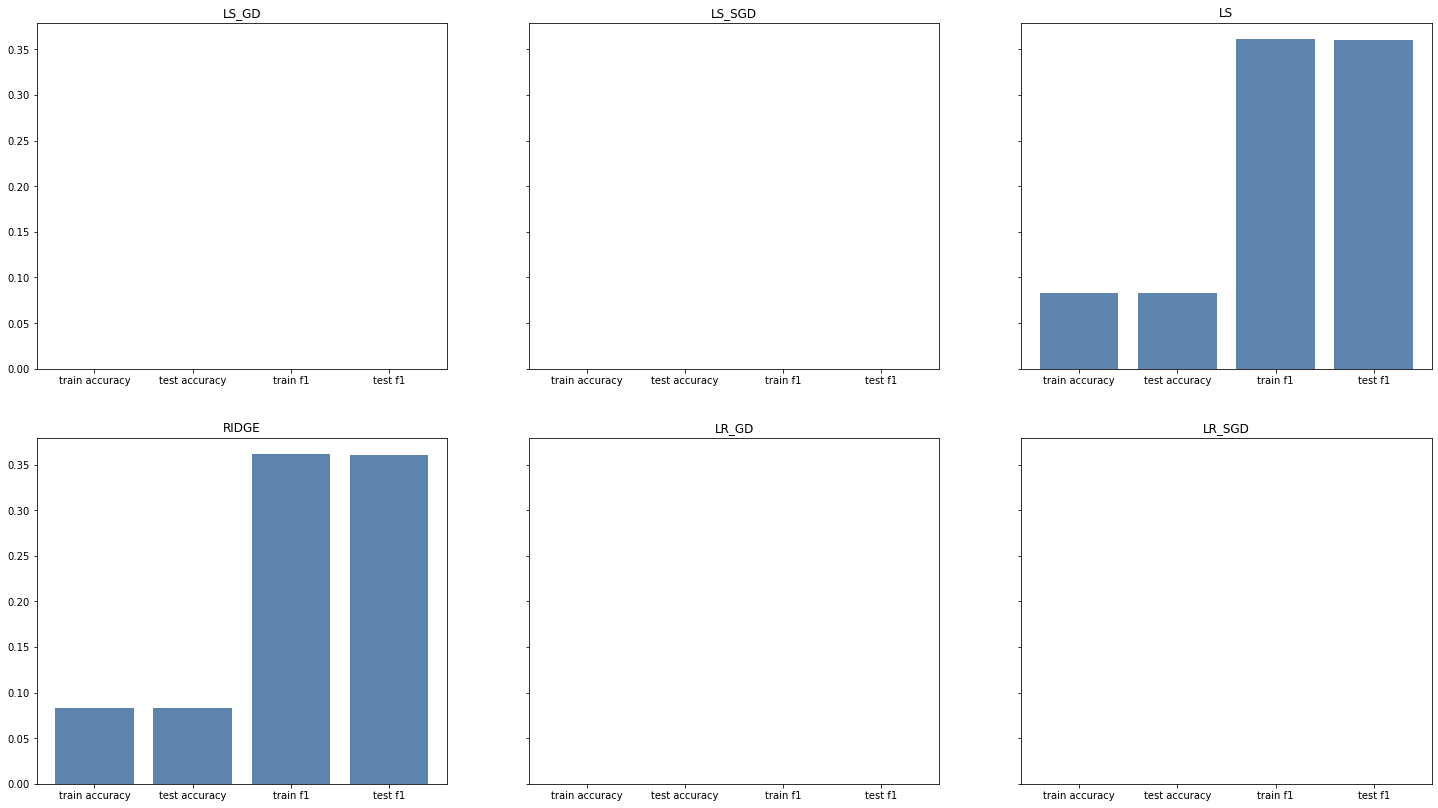

In [19]:
fig, axs = plt.subplots(2,3,figsize=(25,14), sharey=True)
for res in np.arange(results.shape[0]):
        #print(res//3, res%3)
        barWidth = 0.3
        bars = ('train accuracy', 'test accuracy', 'train f1', 'test f1')

        # Create bars
        height = results[res]
        axs[res//3,res%3].bar(bars, height, color=(0.2, 0.4, 0.6, 0.8))
        # Create names on the x-axis
        axs[res//3,res%3].set_title(methods[res])
        

# Show graphic
plt.show()

In [20]:
def hyperparam(method, initial_w = ['DEFAULT'], gamma =['DEFAULT'], lambda_=['DEFAULT'], degree=['DEFAULT']):
    max_iters = 100
    
    initial_w_arr = initial_w
    gammas = gamma
    degrees = degree
    lambdas = lambda_
    
    max_acc = 0
    max_w = 0
    
    opt_ini = 0
    opt_gamma = 0
    opt_lambda = 0
    opt_degree = 0
    for lambda_ in lambda_:
        print(lambda_)
        for initial_w in initial_w_arr:
            for gamma in gammas:
               for degree in degrees:
                    rmse_tr_ridge, rmse_te_ridge, acc_train, acc_test, f1_train, f1_test, w = apply_cross_validation(y, tx, k_indices, k_fold, degree, method, initial_w, max_iters, gamma, lambda_)
                    if acc_test > max_acc:
                        max_acc = acc_test
                        max_w = w
                        opt_ini = initial_w
                        opt_gamma = gamma
                        opt_lambda = lambda_
                        opt_degree = degree
    return(max_acc, max_w, opt_ini, opt_gamma, opt_lambda, opt_degree)

In [23]:
max_acc, w_rr, _ , _, opt_lambda, _ = hyperparam(ridge_regression, lambda_=np.linspace(0.1, 100, 100));
print("BEST LAMBDA =", opt_lambda)

0.1
Ridge regression: train loss is  0.9056071357744623
[14727, 6191, 116975, 49607]
[4963, 2012, 39155, 16370]
Ridge regression: train loss is  0.9053559029339339
[14555, 5988, 117359, 49598]
[5013, 2037, 38949, 16501]
Ridge regression: train loss is  0.9047980091380434
[14801, 6046, 117212, 49441]
[4799, 2032, 39043, 16626]
Ridge regression: train loss is  0.9052947197274471
[14769, 6077, 117151, 49503]
[4835, 2019, 39086, 16560]
Averaged train rmse after 4-fold cross-validation = 0.90526394
Averaged test rmse after 4-fold cross-validation = 0.90536078
Averaged train accuracy after 4-fold cross-validation = 0.08
Averaged test accuracy after 4-fold cross-validation = 0.08
Averaged train F1-score after 4-fold cross-validation = 0.35
Averaged test F1-score after 4-fold cross-validation = 0.35
1.1090909090909091
Ridge regression: train loss is  0.9077676997863469
[14232, 5917, 117249, 50102]
[4780, 1931, 39236, 16553]
Ridge regression: train loss is  0.9074744610008807
[14075, 5795, 1175

[13760, 5412, 117846, 50482]
[4483, 1847, 39228, 16942]
Ridge regression: train loss is  0.9080782283709141
[13734, 5478, 117750, 50538]
[4518, 1813, 39292, 16877]
Averaged train rmse after 4-fold cross-validation = 0.90802114
Averaged test rmse after 4-fold cross-validation = 0.90806963
Averaged train accuracy after 4-fold cross-validation = 0.07
Averaged test accuracy after 4-fold cross-validation = 0.07
Averaged train F1-score after 4-fold cross-validation = 0.33
Averaged test F1-score after 4-fold cross-validation = 0.33
11.2
Ridge regression: train loss is  0.9084190595026745
[13683, 5518, 117648, 50651]
[4600, 1795, 39372, 16733]
Ridge regression: train loss is  0.9081262186973901
[13525, 5380, 117967, 50628]
[4623, 1808, 39178, 16891]
Ridge regression: train loss is  0.9075545310450578
[13717, 5377, 117881, 50525]
[4464, 1835, 39240, 16961]
Ridge regression: train loss is  0.908108850286739
[13691, 5438, 117790, 50581]
[4512, 1799, 39306, 16883]
Averaged train rmse after 4-fold 

Ridge regression: train loss is  0.908728333663043
[13295, 5222, 117944, 51039]
[4429, 1714, 39453, 16904]
Ridge regression: train loss is  0.9084412474215123
[13080, 5088, 118259, 51073]
[4497, 1713, 39273, 17017]
Ridge regression: train loss is  0.9078821739561465
[13287, 5084, 118174, 50955]
[4337, 1730, 39345, 17088]
Ridge regression: train loss is  0.9084242526948462
[13258, 5127, 118101, 51014]
[4363, 1704, 39401, 17032]
Averaged train rmse after 4-fold cross-validation = 0.90836900
Averaged test rmse after 4-fold cross-validation = 0.90841288
Averaged train accuracy after 4-fold cross-validation = 0.07
Averaged test accuracy after 4-fold cross-validation = 0.07
Averaged train F1-score after 4-fold cross-validation = 0.32
Averaged test F1-score after 4-fold cross-validation = 0.32
22.3
Ridge regression: train loss is  0.9087607275840551
[13254, 5182, 117984, 51080]
[4419, 1700, 39467, 16914]
Ridge regression: train loss is  0.9084740535185969
[13044, 5065, 118282, 51109]
[4487, 1

[12719, 4807, 118540, 51434]
[4363, 1637, 39349, 17151]
Ridge regression: train loss is  0.9082327143790666
[12910, 4842, 118416, 51332]
[4226, 1630, 39445, 17199]
Ridge regression: train loss is  0.9087667952611211
[12918, 4878, 118350, 51354]
[4240, 1603, 39502, 17155]
Averaged train rmse after 4-fold cross-validation = 0.90871092
Averaged test rmse after 4-fold cross-validation = 0.90875226
Averaged train accuracy after 4-fold cross-validation = 0.07
Averaged test accuracy after 4-fold cross-validation = 0.07
Averaged train F1-score after 4-fold cross-validation = 0.31
Averaged test F1-score after 4-fold cross-validation = 0.31
32.39090909090909
Ridge regression: train loss is  0.9090989231744849
[12883, 4928, 118238, 51451]
[4297, 1621, 39546, 17036]
Ridge regression: train loss is  0.9088152157684085
[12683, 4777, 118570, 51470]
[4353, 1629, 39357, 17161]
Ridge regression: train loss is  0.9082689109685808
[12879, 4810, 118448, 51363]
[4214, 1620, 39455, 17211]
Ridge regression: t

[4114, 1535, 39540, 17311]
Ridge regression: train loss is  0.9091303339855228
[12562, 4649, 118579, 51710]
[4129, 1518, 39587, 17266]
Averaged train rmse after 4-fold cross-validation = 0.90907302
Averaged test rmse after 4-fold cross-validation = 0.90911243
Averaged train accuracy after 4-fold cross-validation = 0.07
Averaged test accuracy after 4-fold cross-validation = 0.07
Averaged train F1-score after 4-fold cross-validation = 0.31
Averaged test F1-score after 4-fold cross-validation = 0.31
42.481818181818184
Ridge regression: train loss is  0.9094575771221618
[12565, 4672, 118494, 51769]
[4191, 1533, 39634, 17142]
Ridge regression: train loss is  0.9091754434977318
[12344, 4543, 118804, 51809]
[4240, 1569, 39417, 17274]
Ridge regression: train loss is  0.9086396906571879
[12522, 4587, 118671, 51720]
[4098, 1526, 39549, 17327]
Ridge regression: train loss is  0.9091675569835753
[12533, 4621, 118607, 51739]
[4115, 1516, 39589, 17280]
Averaged train rmse after 4-fold cross-validati

Ridge regression: train loss is  0.9090224889921682
[12179, 4405, 118853, 52063]
[3992, 1472, 39603, 17433]
Ridge regression: train loss is  0.9095462009251306
[12182, 4441, 118787, 52090]
[4013, 1450, 39655, 17382]
Averaged train rmse after 4-fold cross-validation = 0.90948681
Averaged test rmse after 4-fold cross-validation = 0.90952450
Averaged train accuracy after 4-fold cross-validation = 0.06
Averaged test accuracy after 4-fold cross-validation = 0.06
Averaged train F1-score after 4-fold cross-validation = 0.30
Averaged test F1-score after 4-fold cross-validation = 0.30
53.58181818181818
Ridge regression: train loss is  0.9098677130473765
[12201, 4470, 118696, 52133]
[4059, 1465, 39702, 17274]
Ridge regression: train loss is  0.9095864474138002
[11961, 4335, 119012, 52192]
[4115, 1496, 39490, 17399]
Ridge regression: train loss is  0.9090612413860464
[12148, 4383, 118875, 52094]
[3985, 1466, 39609, 17440]
Ridge regression: train loss is  0.9095845972914443
[12151, 4425, 118803, 5

Averaged train rmse after 4-fold cross-validation = 0.90987172
Averaged test rmse after 4-fold cross-validation = 0.90990810
Averaged train accuracy after 4-fold cross-validation = 0.06
Averaged test accuracy after 4-fold cross-validation = 0.06
Averaged train F1-score after 4-fold cross-validation = 0.29
Averaged test F1-score after 4-fold cross-validation = 0.29
63.67272727272727
Ridge regression: train loss is  0.9102493664324126
[11897, 4292, 118874, 52437]
[3948, 1417, 39750, 17385]
Ridge regression: train loss is  0.9099684455921155
[11684, 4149, 119198, 52469]
[3997, 1437, 39549, 17517]
Ridge regression: train loss is  0.9094519851877125
[11875, 4192, 119066, 52367]
[3875, 1406, 39669, 17550]
Ridge regression: train loss is  0.909972254166493
[11822, 4251, 118977, 52450]
[3932, 1378, 39727, 17463]
Averaged train rmse after 4-fold cross-validation = 0.90991051
Averaged test rmse after 4-fold cross-validation = 0.90994677
Averaged train accuracy after 4-fold cross-validation = 0.0

Ridge regression: train loss is  0.9103547830894396
[11433, 3976, 119371, 52720]
[3898, 1387, 39599, 17616]
Ridge regression: train loss is  0.9098463762141134
[11582, 4021, 119237, 52660]
[3799, 1348, 39727, 17626]
Ridge regression: train loss is  0.9103642593876996
[11552, 4070, 119158, 52720]
[3842, 1319, 39786, 17553]
Averaged train rmse after 4-fold cross-validation = 0.91030026
Averaged test rmse after 4-fold cross-validation = 0.91033538
Averaged train accuracy after 4-fold cross-validation = 0.06
Averaged test accuracy after 4-fold cross-validation = 0.06
Averaged train F1-score after 4-fold cross-validation = 0.29
Averaged test F1-score after 4-fold cross-validation = 0.29
74.77272727272727
Ridge regression: train loss is  0.910674386140901
[11601, 4102, 119064, 52733]
[3862, 1352, 39815, 17471]
Ridge regression: train loss is  0.9103935472670198
[11395, 3957, 119390, 52758]
[3890, 1384, 39602, 17624]
Ridge regression: train loss is  0.9098859113953529
[11555, 4010, 119248, 52

Ridge regression: train loss is  0.9107578740635324
[11310, 3924, 119304, 52962]
[3744, 1272, 39833, 17651]
Averaged train rmse after 4-fold cross-validation = 0.91069156
Averaged test rmse after 4-fold cross-validation = 0.91072567
Averaged train accuracy after 4-fold cross-validation = 0.06
Averaged test accuracy after 4-fold cross-validation = 0.06
Averaged train F1-score after 4-fold cross-validation = 0.28
Averaged test F1-score after 4-fold cross-validation = 0.28
84.86363636363636
Ridge regression: train loss is  0.9110625616292404
[11362, 3948, 119218, 52972]
[3783, 1307, 39860, 17550]
Ridge regression: train loss is  0.9107816114117379
[11149, 3837, 119510, 53004]
[3811, 1326, 39660, 17703]
Ridge regression: train loss is  0.910281375117131
[11329, 3878, 119380, 52913]
[3696, 1291, 39784, 17729]
Ridge regression: train loss is  0.9107972388296376
[11280, 3912, 119316, 52992]
[3736, 1271, 39834, 17659]
Averaged train rmse after 4-fold cross-validation = 0.91073070
Averaged test

Ridge regression: train loss is  0.9114503263554664
[11132, 3823, 119343, 53202]
[3697, 1274, 39893, 17636]
Ridge regression: train loss is  0.9111691294568669
[10915, 3706, 119641, 53238]
[3736, 1287, 39699, 17778]
Ridge regression: train loss is  0.9106757812443744
[11096, 3756, 119502, 53146]
[3624, 1243, 39832, 17801]
Ridge regression: train loss is  0.9111902258996009
[11052, 3783, 119445, 53220]
[3664, 1225, 39880, 17731]
Averaged train rmse after 4-fold cross-validation = 0.91112137
Averaged test rmse after 4-fold cross-validation = 0.91115448
Averaged train accuracy after 4-fold cross-validation = 0.06
Averaged test accuracy after 4-fold cross-validation = 0.06
Averaged train F1-score after 4-fold cross-validation = 0.28
Averaged test F1-score after 4-fold cross-validation = 0.28
95.96363636363635
Ridge regression: train loss is  0.9114890165512964
[11108, 3803, 119363, 53226]
[3685, 1269, 39898, 17648]
Ridge regression: train loss is  0.9112077884628683
[10899, 3692, 119655, 5

In [ ]:
DATA_TEST_PATH = r'C:/Users/Tomas/GitHub/ML_course/projects/project1/data/test1.csv/test.csv' # TODO: download train data and supply path here 
_, tx_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH =  r'C:/Users/Tomas/GitHub/ML_course/projects/project1/data/test_rr.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w_rr, tx_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)